This notebook contains the experiments for the case where model have access to initial web context. Here we try to have the models come up with novel search queries during the debate for disambiguation of their argument.

In [1]:
import sys
sys.path.append('..')

import argparse
import torch

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

import requests
from PIL import Image
import json
from transformers import TextStreamer

from utils.data import get_data, show_data
from utils.prompts import initial_prompt_with_context, round1_prompt, debate_prompt
from utils.external_retrieval import get_query_answer

In [2]:
MODEL_NAME = "liuhaotian/llava-v1.6-34b"
temperature = 0.2
max_new_tokens = 512
num_models = 2
models = []

disable_torch_init()

model_name = get_model_name_from_path(MODEL_NAME)
for i in range(num_models):
    tokenizer, model, image_processor, context_len = load_pretrained_model(MODEL_NAME, model_base=None, model_name=model_name, load_8bit=False, load_4bit=False, device_map="auto")
    models.append({"tokenizer":tokenizer, "model":model, "image_processor":image_processor, "context_len":context_len})

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assi

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

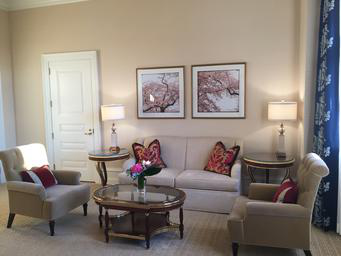

Caption:  A teen lounge at Beaches Turks and Caicos Resort Villages and Spa
Misinformation (Ground Truth): True


In [3]:
if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

conv = []
roles = []

for i in range(num_models):
    conv.append(conv_templates[conv_mode].copy())
    if "mpt" in model_name.lower():
        roles.append(('user', 'assistant'))
    else:
        roles.append(conv[i].roles)

data_idx = 23
image, caption, img_path, data_annotation = get_data(data_idx)
display(image)
show_data(data_idx)
image_size = image.size

# Similar operation in model_worker.py
image_tensor = process_images([image], models[0]['image_processor'], models[0]['model'].config)
if type(image_tensor) is list:
    image_tensor = [image.to(models[0]['model'].device, dtype=torch.float16) for image in image_tensor]
else:
    image_tensor = image_tensor.to(models[0]['model'].device, dtype=torch.float16)


In [4]:
def generate_output(i, conv, models, image_tensor, temperature, image_size, max_new_tokens):
    print("AGENT - {}: ".format(i+1))
    prompt = conv[i].get_prompt()

    input_ids = tokenizer_image_token(prompt, models[i]['tokenizer'], IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(models[i]['model'].device)
    stop_str = conv[i].sep if conv[i].sep_style != SeparatorStyle.TWO else conv[i].sep2
    keywords = [stop_str]
    streamer = TextStreamer(models[i]['tokenizer'], skip_prompt=True, skip_special_tokens=True)

    with torch.inference_mode():
        output_ids = models[i]['model'].generate(
            input_ids,
            images=image_tensor,
            image_sizes=[image_size],
            do_sample=True if temperature > 0 else False,
            temperature=temperature,
            max_new_tokens=max_new_tokens,
            streamer=streamer,
            use_cache=True)

    outputs = models[i]['tokenizer'].decode(output_ids[0]).strip()
    return outputs

def retrieve_summary(key):
    with open("../utils/summaries.json", "r") as f:
        data = json.load(f)
    return data[key]

In [5]:
def round1_prompt_with_disambiguation(role, text):
    prompt = """ {}: This is what I think: {}. Do you agree with me? If you think I am wrong then convince me why you are correct.
            Clearly state your reasoning and tell me if I am missing out on some important information or am making some logical error.
            Do not describe the image. At the end give a definite YES or NO answer to this question: IS THIS MISINFORMATION?
            Note: The caption does not have to describe the image exactly, they just have to be contextually related.
            ONLY if you think my argument has some ambiguities then generate 1 disambiguation query DELIMITED BY <search_query> and </search_query> TAGS, that I can use to search the web to either correct my wrong argument or strengthen my exisiting argument. 
            MAKE SURE YOU ENCLOSE THE QUERY WITHIN <search_query> and </search_query> TAGS.
            """.format(role, text)
    return prompt

In [6]:

def debate_prompt_with_disambiguation(role, text):
    prompt = """ {}: I see what you mean and this is what I think: {}. Do you agree with me?
                If not then point out the inconsistencies in my argument (e.g. location, time or person related logical confusion) and explain why you are correct. 
                If you disagree with me then clearly state why and what information I am overlooking.
                At the end give a definite YES or NO answer to this question: IS THIS MISINFORMATION?
                Note: The caption does not have to describe the image exactly, they just have to be contextually related.
                ONLY if you think my response has some ambiguities or missing information then generate 1 disambiguation query DELIMITED BY <search_query> and </search_query> TAGS, that I can use to search the web to either correct my wrong argument or strengthen my exisiting argument. 
                MAKE SURE YOU ENCLOSE THE QUERY WITHIN <search_query> and </search_query> tags.
            """.format(role, text)
    return prompt

In [7]:
def refine_prompt(role, query, search_result, prev_response):
    prompt = """{}: In order to refine your earlier response, I searched the web with this query: {}. 
                This is the search result I found: {}.
                Based on this result, refine your earlier response to include more details and explanations.
                Remove the disambiguation query if there is one demilited by <search_query> tags.
                Earlier response: {}.
    """.format(role, query, search_result, prev_response)
    return prompt

In [8]:
def retrieve_stored_url(key, file_path="../utils/retrieval_urls.json"):
    with open(file_path, 'r') as f:
        data = json.load(f)
    urls = data[key]
    return urls

In [9]:
def refine_response(data_idx, i, conv, models, image_tensor, temperature, image_size, max_new_tokens, role, query, prev_response):
    print("REFINING RESPONSE!! - AGENT: ", i+1)
    key = str(data_annotation['id'])+"_"+str(data_annotation['image_id'])
    matching_urls = retrieve_stored_url(key)
    print("!!!!!!!!!!! QUERY BEING PASSED: ", query)
    #print("************* PREVIOUS RESPONSE: ", prev_response)
    search_result = get_query_answer(matching_urls, query)
    print("Search result for the query: ", search_result)
    inp = refine_prompt(role, query, search_result, prev_response)
    conv[i].append_message(conv[i].roles[0], inp)
    conv[i].append_message(conv[i].roles[1], None)
    outputs = generate_output(i, conv, models, image_tensor, temperature, image_size, max_new_tokens)
    conv[i].messages.pop()
    conv[i].messages.pop()
    return conv, outputs

In [10]:
def initial_prompt_with_context_1(role, text, summary):
    prompt = """{}: This is a summary of news articles related to the image: {}
                    Based on this summary, tell me why the caption belongs with the image.
                    Note the image does not need to show exactly what the caption mentions, they just have to be related.
                    CAPTION: {}
                    Note that the image is real and the caption is correct. It has not been digitally altered. Carefully examine the image for any known entities, watermarks, dates, landmarks, flags and other details which could tell you about the location, time or other important information to better inform your answer.
                    Explain your answer in detail.
                    At the end give a definite NO answer to this question: IS THIS IMAGE-CAPTION PAIR MISINFORMATION?""".format(role, summary, text)
    return prompt

In [11]:
def initial_prompt_with_context_2(role, text, summary):
    prompt = """{}: This is a summary of news articles related to the image: {}
                    Based on this summary, you must argue that the caption given below does NOT belong to the image and IS being used to spread false
                    information to mislead people.
                    Note that the image does not need to show exactly what the caption mentions, they just have to be related.
                    CAPTION: {}
                    Note that the image is real and caption is false. It has not been digitally altered. Carefully examine the image for any known entities, watermarks, dates, landmarks, flags and other details which could tell you about the location, time or other important information to better inform your answer.
                    Explain your answer in detail.
                    At the end give a definite YES answer to this question: IS THIS IMAGE-CAPTION PAIR MISINFORMATION?""".format(role, summary, text)
    return prompt

In [12]:
temperature = 0.2
max_new_tokens = 512
num_models = 2
num_rounds = 2

In [13]:
search_result = ""
search_done = False
summary_key = str(data_annotation['id'])+"_"+str(data_annotation["image_id"])
context = retrieve_summary(summary_key)
print("CONTEXT: \n\n", context)
image_size = image.size
queries = {0:"", 1:""}
temp = ""
model_responses = {}
for i in range(num_models):
    model_responses[i] = {"falsified":"", "output":""}
for round in range(num_rounds+1):
    for i in range(num_models):
        if round == 0:
            if i == 0:
                inp = initial_prompt_with_context_1(roles[i][0], caption, context)
            else:
                inp = initial_prompt_with_context_2(roles[i][0], caption, context)
        elif round == 1:
            if i == 1:
                inp = round1_prompt_with_disambiguation(roles[i][0], temp)
            else:
                inp = round1_prompt_with_disambiguation(roles[i][0], conv[(i+1)%num_models].messages[-1][-1])
        else:
            inp = debate_prompt_with_disambiguation(roles[i][0], conv[(i+1)%num_models].messages[-1][-1])
        if image is not None:
            # first message
            if models[i]['model'].config.mm_use_im_start_end:
                inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
            else:
                inp = DEFAULT_IMAGE_TOKEN + '\n' + inp
            if round == 0 and i == 1:
                image = None

        conv[i].append_message(conv[i].roles[0], inp)
        conv[i].append_message(conv[i].roles[1], None)
        outputs = generate_output(i, conv, models, image_tensor, temperature, image_size, max_new_tokens)
        conv[i].messages[-1][-1] = outputs
        #print(outputs)
        if "<search_query>" in outputs:
            queries[(i+1)%num_models] = outputs[outputs.find("<search_query>")+len("<search_query>"):outputs.find("</search_query>")]

        if i == 0 and round == 0:
            temp = outputs
        #final answer from the model
        if "YES" in outputs or "Yes" in outputs:
            model_responses[i]["falsified"] = True
            model_responses[i]["output"] = outputs
        elif "NO" in outputs or "No" in outputs:
            model_responses[i]["falsified"] = False
            model_responses[i]["output"] = outputs
        else:
            model_responses[i]["falsified"] = "Unsure"
            model_responses[i]["output"] = outputs
    print(queries)
    if queries[0] != "":
        print("agent-1 query!")
        conv, outputs = refine_response(data_idx, 0, conv, models, image_tensor, temperature, image_size, max_new_tokens, roles[0][0], queries[0], conv[0].messages[-1][-1])
        model_responses[0]['outputs'] = outputs
        #print("PREV MESSAGE: ", conv[0].messages[-1][-1])
        conv[0].messages[-1][-1] = outputs
        if "YES" in outputs or "Yes" in outputs:
            model_responses[0]["falsified"] = True
            model_responses[0]["output"] = outputs
        elif "NO" in outputs or "No" in outputs:
            model_responses[0]["falsified"] = False
            model_responses[0]["output"] = outputs
        else:
            model_responses[0]["falsified"] = "Unsure"
            model_responses[0]["output"] = outputs
    if queries[1] != "":
        print("agent-2 query!")
        conv, outputs = refine_response(data_idx, 1, conv, models, image_tensor, temperature, image_size, max_new_tokens, roles[1][0], queries[1], conv[1].messages[-1][-1])
        model_responses[1]['outputs'] = outputs
        #print("PREV MESSAGE: ", conv[1].messages[-1][-1])
        conv[1].messages[-1][-1] = outputs
        if "YES" in outputs or "Yes" in outputs:
            model_responses[1]["falsified"] = True
            model_responses[1]["output"] = outputs
        elif "NO" in outputs or "No" in outputs:
            model_responses[1]["falsified"] = False
            model_responses[1]["output"] = outputs
        else:
            model_responses[1]["falsified"] = "Unsure"
            model_responses[1]["output"] = outputs
        
    if model_responses[0]['falsified'] == model_responses[1]['falsified'] and round != 0:
        print("******************* Models agree!! *****************")
        break

CONTEXT: 

 SUMMARY:
            
            Write a summary of the following text delimited by triple backticks.
            Your response should cover all key points.
            ``````
            SUMMARY:

            The text is asking for a summary of the text delimited by triple backticks. The summary should cover all key points.

            ``````

            SUMMARY:

            The text is asking for a summary of the text delimited by triple backticks. The summary should cover all key points.

            ``````
AGENT - 1: 
The image shows a well-decorated living room with a neutral color palette, featuring a white sofa, two armchairs, a round coffee table, and a vase with flowers. There are framed pictures on the wall, and the room has a cozy and inviting atmosphere. The caption "A teen lounge at Beaches Turks and Caicos Resort Villages and Spa" suggests that this is a space designed for teenagers within the resort. The image does not show any specific details that would

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
Both `max_new_tokens` (=1000) and `max_length`(=3000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Found 3 search results.
Search result for the query:  ANSWER:
            
            Based on the text delimited by triple backticks, there is no mention of "Beaches Turks and Caicos Resort Villages and Spa" or "teen lounge interior design".
AGENT - 1: 
Based on the search result you provided, it is clear that the image does not depict a teen lounge at Beaches Turks and Caicos Resort Villages and Spa. The search result does not mention the resort or the specific type of space shown in the image. The image appears to be a typical living room setting that could be found in a variety of residential or commercial spaces, but there is no evidence to support the claim that it is a teen lounge at a specific resort.

Therefore, the image-caption pair is indeed misinformation.
agent-2 query!
REFINING RESPONSE!! - AGENT:  2
!!!!!!!!!!! QUERY BEING PASSED:   "Beaches Turks and Caicos Resort Villages and Spa" teen lounge 


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Both `max_new_tokens` (=1000) and `max_length`(=3000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Found 3 search results.
Search result for the query:  ANSWER:
            
            Based on the text delimited by triple backticks, there is no mention of "Beaches Turks and Caicos Resort Villages and Spa" or "teen lounge". 
            Sorry no results found!
AGENT - 2: 
Based on your search result, it appears that there is no information available online about the teen lounge at Beaches Turks and Caicos Resort Villages and Spa. This suggests that the caption may not be accurate, and it is reasonable to conclude that the caption is being used to spread misinformation.

While it is not possible to definitively confirm the caption as misinformation based on the image alone, the absence of any information about the teen lounge at Beaches Turks and Caicos Resort Villages and Spa suggests that the caption is not accurate. Therefore, it is reasonable to conclude that the caption is not accurate and is being used to spread misinformation.
******************* Models agree!! **************

: 